# CareHarmony Case Study

You will be using the CMS 2008-2010 Data Entrepreneurs Synthetic PUF beneficiary data files for this project. This dataset is a bit old, but it is a large synthetic dataset that closely mirrors the type of data that we work with. Due to file size limitations, each data type in the CMS Linkable 2008-2010 Medicare DE-SynPUF is released in 20 separate samples (essentially each is a .25% sample)

The DE-SynPUF contains five types of data for the period 2008-2010:
* Beneficiary Summary
* Inpatient Claims
* Outpatient Claims
* Carrier Claims (not included in the current analysis)
* Prescription Drug Events (not included in the current analysis)


To keep things simple, you will be primarily utilizing the beneficiary-level files that can be found in the zip file attached. These data files contain high-level summaries of patient demographics, conditions, and spending for each of the years 2008, 2009, and 2010. It is organized into twenty separate files for each year and organized such that the same patients are retained in each of the yearly files sharing the same index number. Ten files per year are included for completeness, but you may use as many as you like to conduct our analysis. Note that the dataset is indeed synthetic so many relationships we would expect to see in real world data may not hold. Accordingly, in our evaluation we will focus more on our analytical approach than the actual results.

The original source of the files can be found at this link: https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DESample01. Translations for a lot of the common terms provided in the Beneficiary Summary file can be found at this link: https://www.cms.gov/files/document/de-10-codebook.pdf-0.

# CareHarmony Case Study: causal modeling

The health system is also considering deploying a newly developed intervention that reduces the likelihood of developing congestive heart failure (CHF) without impacting any other factors of a patient's health. Before deploying the intervention, they would like to estimate its impact in reducing costs due to the new development of CHF. To help answer this question, please use the data to estimate the impact of a patient being developing diagnosis-level CHF on their total cost in the following year.

In [87]:
import os
import time

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

## Beneficiary data processing

In [103]:
start_time = time.time()

# Define the base directory for our CSV files
base_dir = r'C:\code_personal_use\cms\data\bene'

# List of years we have data for
years = [2008, 2009, 2010]

# Columns to use for each year
columns_2008 = [
    'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD',
    'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN',
    'SP_CNCR', 'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
    'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP',
    'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

columns_2009_2010 = [
    'DESYNPUF_ID', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT',
    'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP', 'BENRES_IP',
    'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR',
    'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to recode BENE_ESRD_IND
def recode_bene_esrd_ind(df, column):
    df[column] = df[column].replace({'Y': 1, '0': 2}).astype(int)
    return df

# Function to rename columns with a suffix
def rename_columns_with_suffix(df, suffix):
    df = df.rename(columns=lambda x: x + suffix if x != 'DESYNPUF_ID' else x)
    return df

# Function to load and preprocess a batch of files for a given year
def load_and_preprocess_batch(file_paths, year):
    columns = columns_2008 if year == 2008 else columns_2009_2010
    parse_dates = ['BENE_BIRTH_DT'] if year == 2008 else None
    date_parser = lambda x: pd.to_datetime(x, format='%Y%m%d') if year == 2008 else None

    # Load and preprocess files in the batch
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(
            file_path,
            usecols=columns,
            parse_dates=parse_dates,
            date_parser=date_parser
        )
        df = recode_bene_esrd_ind(df, 'BENE_ESRD_IND')
        df = rename_columns_with_suffix(df, f'_{year}')
        dfs.append(df)

    # Concatenate all DataFrames in the batch
    return pd.concat(dfs, ignore_index=True)

# Create a dictionary to store DataFrames for each year
dfs_by_year = {}


# Process files in batches
# Adjust the batch size based on our system's memory
batch_size = 5
for year in years:
    file_paths = [os.path.join(base_dir, f'DE1_0_{year}_Beneficiary_Summary_File_Sample_{i}.csv') for i in range(1, 21)]
    batches = [file_paths[i:i + batch_size] for i in range(0, len(file_paths), batch_size)]

    # Load and preprocess each batch
    year_dfs = []
    for batch in batches:
        batch_df = load_and_preprocess_batch(batch, year)
        year_dfs.append(batch_df)

    # Concatenate all batches for the year
    dfs_by_year[year] = pd.concat(year_dfs, ignore_index=True)

# Merge DataFrames for all years on DESYNPUF_ID.
# The inner join ensures that we are keeping patients who have had at least one claim during each of the three years of observation
merged_df = dfs_by_year[2008]
for year in years[1:]:
    merged_df = merged_df.merge(dfs_by_year[year], on='DESYNPUF_ID', how='inner')


#####################################################################################################
# Define the prefixes to check for null values
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
    'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to replace null values with 0 for specified prefixes
def replace_nulls_with_zero(df, prefixes):
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        df[cols] = df[cols].fillna(0)
    return df

merged_df = replace_nulls_with_zero(merged_df, prefixes)

#####################################################################################################

# Calculate Age
def calculate_age(birth_date, reference_date):
    return reference_date.year - birth_date.year - ((reference_date.month, reference_date.day) < (birth_date.month, birth_date.day))

reference_date = datetime.now()  # Using the current date as the reference date
merged_df['Age'] = merged_df['BENE_BIRTH_DT_2008'].apply(lambda x: calculate_age(x, reference_date))

#####################################################################################################

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs in 2008: {dfs_by_year[2008]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2009: {dfs_by_year[2009]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2010: {dfs_by_year[2010]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs after merging: {merged_df["DESYNPUF_ID"].nunique()}')

print("First few rows of the merged DataFrame:")
print(merged_df.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs in 2008: 2326856
Unique IDs in 2009: 2291320
Unique IDs in 2010: 2255098
Unique IDs after merging: 2255098
First few rows of the merged DataFrame:
        DESYNPUF_ID BENE_BIRTH_DT_2008  BENE_SEX_IDENT_CD_2008  \
0  00013D2EFD8E45D1         1923-05-01                       1   
1  00016F745862898F         1943-01-01                       1   
2  0001FDD721E223DC         1936-09-01                       2   
3  00021CA6FF03E670         1941-06-01                       1   
4  00024B3D2352D2D0         1936-08-01                       1   

   BENE_RACE_CD_2008  BENE_ESRD_IND_2008  SP_STATE_CODE_2008  \
0                  1                   2                  26   
1                  1                   2                  39   
2                  1                   2                  39   
3                  5                   2                   6   
4                  1                   2                  52   

   BENE_COUNTY_CD_2008  SP_ALZHDMTA_2008  SP_CHF_2008  SP_CH

In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2255098 entries, 0 to 2255097
Data columns (total 70 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   DESYNPUF_ID             object        
 1   BENE_BIRTH_DT_2008      datetime64[ns]
 2   BENE_SEX_IDENT_CD_2008  int64         
 3   BENE_RACE_CD_2008       int64         
 4   BENE_ESRD_IND_2008      int32         
 5   SP_STATE_CODE_2008      int64         
 6   BENE_COUNTY_CD_2008     int64         
 7   SP_ALZHDMTA_2008        int64         
 8   SP_CHF_2008             int64         
 9   SP_CHRNKIDN_2008        int64         
 10  SP_CNCR_2008            int64         
 11  SP_COPD_2008            int64         
 12  SP_DEPRESSN_2008        int64         
 13  SP_DIABETES_2008        int64         
 14  SP_ISCHMCHT_2008        int64         
 15  SP_OSTEOPRS_2008        int64         
 16  SP_RA_OA_2008           int64         
 17  SP_STRKETIA_2008        int64         
 18  ME

In [105]:
pd.options.display.float_format = '{:.2f}'.format
merged_df.describe(())

,BENE_SEX_IDENT_CD_2008,BENE_RACE_CD_2008,BENE_ESRD_IND_2008,SP_STATE_CODE_2008,BENE_COUNTY_CD_2008,SP_ALZHDMTA_2008,SP_CHF_2008,SP_CHRNKIDN_2008,SP_CNCR_2008,SP_COPD_2008,...,MEDREIMB_IP_2010,BENRES_IP_2010,PPPYMT_IP_2010,MEDREIMB_OP_2010,BENRES_OP_2010,PPPYMT_OP_2010,MEDREIMB_CAR_2010,BENRES_CAR_2010,PPPYMT_CAR_2010,Age
count,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,...,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00,2255098.00
mean,1.56,1.28,1.93,25.72,365.60,1.81,1.72,1.84,1.94,1.86,...,1244.07,144.83,52.24,433.57,131.37,15.01,847.89,239.47,12.86,87.14
std,0.50,0.75,0.26,15.57,266.16,0.39,0.45,0.37,0.24,0.34,...,5138.94,566.76,1374.05,1272.28,367.66,277.87,999.71,284.45,73.24,12.58
min,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,-8000.00,0.00,0.00,-100.00,0.00,0.00,0.00,0.00,0.00,40.00
50%,2.00,1.00,2.00,25.00,330.00,2.00,2.00,2.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,540.00,150.00,0.00,88.00
max,2.00,5.00,2.00,54.00,999.00,2.00,2.00,2.00,2.00,2.00,...,156690.00,37300.00,83000.00,40510.00,11040.00,18000.00,16530.00,3590.00,3000.00,115.00


Looks like we have some negative values for our cost-related features. Let's explore a bit.

Are these reversals? If so, then they should sum to zero for each patient. If not, then the synthetic data generator (Synthea?) hasn't replicated irl medical claims data accurately. Figure it out, dude.

In [106]:
# Specify the prefixes to filter columns
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
    'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Identify columns with the specified prefixes
columns_to_check = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Identify rows where any of the specified columns contain values less than 0
rows_with_negatives = merged_df[(merged_df[columns_to_check] < 0).any(axis=1)]

# Specify the output path for QA of this df
output_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\negative_values.csv'

# Save the filtered DataFrame to a CSV file
rows_with_negatives.to_csv(output_path, index=False)

print(f"DataFrame with negative values saved to {output_path}")

DataFrame with negative values saved to C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\negative_values.csv


Need to work on optimizing this step. It currently takes a little over 5 mins of run time to finish merging all 20 beneficiary files

In [107]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# merged_df = merged_df[merged_df['DESYNPUF_ID'] == '08B6E69DF1A8719A']

# List of columns to sum across years
columns_to_sum = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
    'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Loop through each column and create a new column for the sum across the three years
for col in columns_to_sum:
    merged_df[col + '_SUM'] = merged_df[col + '_2008'] + merged_df[col + '_2009'] + merged_df[col + '_2010']

# Create a list of columns that end with '_SUM'
sum_columns = [col + '_SUM' for col in columns_to_sum]

# Add a new column 'total_sum' that sums all columns ending with '_SUM'
merged_df['total_sum'] = merged_df[sum_columns].sum(axis=1)

# Extract additional columns from the 2008 dataset to serve as our demographic features
additional_columns_08 = merged_df[['DESYNPUF_ID', 'BENE_BIRTH_DT_2008', 'Age', 'BENE_SEX_IDENT_CD_2008', 'BENE_RACE_CD_2008', 'SP_STATE_CODE_2008', 'BENE_COUNTY_CD_2008']]
# Rename columns to more human-readable names
additional_columns_08 = additional_columns_08.rename(columns={
    'BENE_BIRTH_DT_2008': 'Birth_Date',
    'BENE_SEX_IDENT_CD_2008': 'Gender',
    'BENE_RACE_CD_2008': 'Race',
    'SP_STATE_CODE_2008': 'State',
    'BENE_COUNTY_CD_2008': 'County'
})

# Export the wide format DataFrame to a CSV file for QA
# output_path_wide = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_wide.csv'
# merged_df.to_csv(output_path_wide, index=False)

# Reshape the DataFrame from wide to long format for the specified columns
columns_to_reshape = ['DESYNPUF_ID'] + [col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']]
df_wide = merged_df[columns_to_reshape]

# Use pd.melt to reshape the DataFrame to long format
df_long = pd.melt(df_wide, id_vars=['DESYNPUF_ID'],
                  value_vars=[col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']],
                  var_name='Year_Column', value_name='Value')

# Split the 'Year_Column' to extract the year information and the original column name
df_long['Year'] = df_long['Year_Column'].str.extract(r'(\d{4})$')
df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')

# Convert 'Year' to integer
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Sum 'Value' by 'Year' and 'DESYNPUF_ID' to create 'annual_cost'
annual_cost = df_long.groupby(['DESYNPUF_ID', 'Year'])['Value'].sum().reset_index()
annual_cost.rename(columns={'Value': 'annual_cost'}, inplace=True)

# Finalize the long format DataFrame to include DESYNPUF_ID, Year, and annual_cost
df_long_final = annual_cost

# Merge additional columns from 2008 dataset
df_long_final = df_long_final.merge(additional_columns_08, on='DESYNPUF_ID', how='left')

# Export the long format DataFrame to a CSV file for QA
output_path_long = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_long.csv'
df_long_final.to_csv(output_path_long, index=False)

# Display the first few rows of the resulting DataFrames
print("Wide format DataFrame:")
print(merged_df.head())
print("\nLong format DataFrame:")
print(df_long_final.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38248\1489424456.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')


Wide format DataFrame:
        DESYNPUF_ID BENE_BIRTH_DT_2008  BENE_SEX_IDENT_CD_2008  \
0  00013D2EFD8E45D1         1923-05-01                       1   
1  00016F745862898F         1943-01-01                       1   
2  0001FDD721E223DC         1936-09-01                       2   
3  00021CA6FF03E670         1941-06-01                       1   
4  00024B3D2352D2D0         1936-08-01                       1   

   BENE_RACE_CD_2008  BENE_ESRD_IND_2008  SP_STATE_CODE_2008  \
0                  1                   2                  26   
1                  1                   2                  39   
2                  1                   2                  39   
3                  5                   2                   6   
4                  1                   2                  52   

   BENE_COUNTY_CD_2008  SP_ALZHDMTA_2008  SP_CHF_2008  SP_CHRNKIDN_2008  ...  \
0                  950                 2            2                 2  ...   
1                  230             

In [7]:
df_long_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DESYNPUF_ID  object        
 1   Year         int64         
 2   annual_cost  float64       
 3   Birth_Date   datetime64[ns]
 4   Age          int64         
 5   Gender       int64         
 6   Race         int64         
 7   State        int64         
 8   County       int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 490.3+ MB


This code block needs further optimization. It currently takes close to 15 mins to process the diagnosis data for all 20 samples of beneficiary data

In [8]:
start_time = time.time()

# merged_df_qa = merged_df[merged_df['DESYNPUF_ID'] == '00048EF1F4791C68']

# Define the diagnosis columns and prefixes
diagnosis_columns = [
    'DESYNPUF_ID',
    'SP_ALZHDMTA_2008', 'SP_CHF_2008', 'SP_CHRNKIDN_2008', 'SP_CNCR_2008', 'SP_COPD_2008',
    'SP_DEPRESSN_2008', 'SP_DIABETES_2008', 'SP_ISCHMCHT_2008', 'SP_OSTEOPRS_2008',
    'SP_RA_OA_2008', 'SP_STRKETIA_2008', 'BENE_ESRD_IND_2008',
    'SP_ALZHDMTA_2009', 'SP_CHF_2009', 'SP_CHRNKIDN_2009', 'SP_CNCR_2009', 'SP_COPD_2009',
    'SP_DEPRESSN_2009', 'SP_DIABETES_2009', 'SP_ISCHMCHT_2009', 'SP_OSTEOPRS_2009',
    'SP_RA_OA_2009', 'SP_STRKETIA_2009', 'BENE_ESRD_IND_2009',
    'SP_ALZHDMTA_2010', 'SP_CHF_2010', 'SP_CHRNKIDN_2010', 'SP_CNCR_2010', 'SP_COPD_2010',
    'SP_DEPRESSN_2010', 'SP_DIABETES_2010', 'SP_ISCHMCHT_2010', 'SP_OSTEOPRS_2010',
    'SP_RA_OA_2010', 'SP_STRKETIA_2010', 'BENE_ESRD_IND_2010'
]

# Create the diagnoses DataFrame from the main DataFrame
diagnoses = merged_df[diagnosis_columns]

# List of diagnosis prefixes
diagnosis_prefixes = [
    'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
    'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND'
]

# Initialize an empty DataFrame to store the long format data
diagnoses_long_list = []

# Transform each set of columns to long format and append them to the list
for prefix in diagnosis_prefixes:
    columns = [f'{prefix}_2008', f'{prefix}_2009', f'{prefix}_2010']
    df_long = pd.melt(diagnoses, id_vars=['DESYNPUF_ID'], value_vars=columns,
                      var_name='Year', value_name=prefix)
    df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})$').astype(int)
    diagnoses_long_list.append(df_long)


# Combine all long format DataFrames
diagnoses_long = diagnoses_long_list[0]
for df_long in diagnoses_long_list[1:]:
    diagnoses_long = diagnoses_long.merge(df_long, on=['DESYNPUF_ID', 'Year'], how='outer')

#############################################################################################################################
# Define New CHF
# Sort the data by DESYNPUF_ID and Year
diagnoses_long = diagnoses_long.sort_values(by=['DESYNPUF_ID', 'Year'])
# Create a column to identify if there was a transition from 2 to 1
diagnoses_long['New_CHF'] = (diagnoses_long['SP_CHF'] == 1) & (diagnoses_long.groupby('DESYNPUF_ID')['SP_CHF'].shift(1) == 2)
# Group by DESYNPUF_ID to determine if new CHF was developed
new_chf = diagnoses_long.groupby('DESYNPUF_ID')['New_CHF'].max().reset_index()
# Replace boolean values with integers (1 for True, 2 for False)
new_chf['New_CHF'] = new_chf['New_CHF'].apply(lambda x: 1 if x else 2)
# Merge the New_CHF column back into the diagnoses_long DataFrame
diagnoses_long = diagnoses_long.merge(new_chf, on='DESYNPUF_ID', suffixes=('', '_calc'))
#############################################################################################################################


# Export the long format DataFrame to a CSV file for QA
output_path_long = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\dx_data_long.csv'
diagnoses_long.to_csv(output_path_long, index=False)


# Display the transformed long DataFrame
print("Long format Diagnoses DataFrame:")
print(diagnoses_long)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Long format Diagnoses DataFrame:
              DESYNPUF_ID  Year  SP_ALZHDMTA  SP_CHF  SP_CHRNKIDN  SP_CNCR  \
0        00000B48BCF4AD29  2008            1       1            1        1   
1        00000B48BCF4AD29  2009            1       1            2        2   
2        00000B48BCF4AD29  2010            2       1            2        2   
3        0000141F2FECE9BC  2008            2       2            2        2   
4        0000141F2FECE9BC  2009            2       2            2        2   
...                   ...   ...          ...     ...          ...      ...   
6426856  FFFFF4859B6D7402  2009            2       2            1        2   
6426857  FFFFF4859B6D7402  2010            2       2            2        2   
6426858  FFFFFC6B1F91F551  2008            2       2            2        2   
6426859  FFFFFC6B1F91F551  2009            2       2            2        2   
6426860  FFFFFC6B1F91F551  2010            2       2            2        2   

         SP_COPD  SP_DEPRESSN 

In [108]:
# Use value_counts to count New CHF cases
new_chf_counts1 = diagnoses_long.groupby('New_CHF_calc')['DESYNPUF_ID'].nunique()
print(new_chf_counts1)

New_CHF_calc
1     570892
2    1571395
Name: DESYNPUF_ID, dtype: int64


In [109]:
diagnoses_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   DESYNPUF_ID    object
 1   Year           int32 
 2   SP_ALZHDMTA    int64 
 3   SP_CHF         int64 
 4   SP_CHRNKIDN    int64 
 5   SP_CNCR        int64 
 6   SP_COPD        int64 
 7   SP_DEPRESSN    int64 
 8   SP_DIABETES    int64 
 9   SP_ISCHMCHT    int64 
 10  SP_OSTEOPRS    int64 
 11  SP_RA_OA       int64 
 12  SP_STRKETIA    int64 
 13  BENE_ESRD_IND  int32 
 14  New_CHF        bool  
 15  New_CHF_calc   int64 
dtypes: bool(1), int32(2), int64(12), object(1)
memory usage: 741.6+ MB


In [115]:
start_time = time.time()

# Merge diagnoses_long to df_long_final by 'DESYNPUF_ID' and 'Year'
bene_df = pd.merge(df_long_final, diagnoses_long, on=['DESYNPUF_ID', 'Year'], how='outer')

# Ensure the data is sorted by DESYNPUF_ID and Year
bene_df = bene_df.sort_values(by=['DESYNPUF_ID', 'Year'])

# Drop the 'Year' column
bene_df = bene_df.drop(columns=['Year'])

# Group by 'DESYNPUF_ID' and aggregate as required
agg_dict = {
    'Age': 'max',
    'Gender': 'max',
    'Race': 'max',
    'State': 'max',
    'County': 'max',
    'annual_cost': 'sum',
    'SP_ALZHDMTA': 'min',
    'New_CHF_calc': 'min',
    'SP_CHRNKIDN': 'min',
    'SP_CNCR': 'min',
    'SP_COPD': 'min',
    'SP_DEPRESSN': 'min',
    'SP_DIABETES': 'min',
    'SP_ISCHMCHT': 'min',
    'SP_OSTEOPRS': 'min',
    'SP_RA_OA': 'min',
    'SP_STRKETIA': 'min',
    'BENE_ESRD_IND': 'min'
}

# Perform the aggregation
bene_df = bene_df.groupby('DESYNPUF_ID').agg(agg_dict).reset_index()

# Flatten the MultiIndex columns
bene_df.columns = ['_'.join(filter(None, col)).strip() for col in bene_df.columns]

# Remove suffixes '_max', '_min', and '_sum' from column names
bene_df.columns = [col.replace('_max', '').replace('_min', '').replace('_sum', '') for col in bene_df.columns]

# Rename the aggregated columns
bene_df = bene_df.rename(columns={
    'annual_cost': 'total_cost'
})

# Define the path to save the CSV file for QA
output_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\final_merged_data.csv'

# Export the final DataFrame to a CSV file
bene_df.to_csv(output_path, index=False)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 55.62655830383301 seconds to run.


In [116]:
bene_df.head()

,D_E_S_Y_N_P_U_F___I_D,A_g_e,G_e_n_d_e_r,R_a_c_e,S_t_a_t_e,C_o_u_n_t_y,a_n_n_u_a_l___c_o_s_t,S_P___A_L_Z_H_D_M_T_A,N_e_w___C_H_F___c_a_l_c,S_P___C_H_R_N_K_I_D_N,S_P___C_N_C_R,S_P___C_O_P_D,S_P___D_E_P_R_E_S_S_N,S_P___D_I_A_B_E_T_E_S,S_P___I_S_C_H_M_C_H_T,S_P___O_S_T_E_O_P_R_S,S_P___R_A___O_A,S_P___S_T_R_K_E_T_I_A,B_E_N_E___E_S_R_D___I_N_D
0,000002F7E0A96C32,104,2,2,5,400,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000B48BCF4AD29,100,2,5,10,260,108092.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00
2,0000141F2FECE9BC,50,2,1,39,560,5308.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00
3,00001C24EE7B06AC,88,1,1,11,530,3040.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000022FFDB0BE2C7,85,1,1,24,260,290.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00


In [117]:
# Use value_counts to count New CHF cases
new_chf_counts2 = bene_df.groupby('New_CHF_calc')['DESYNPUF_ID'].nunique()
print(new_chf_counts2)

KeyError: 'New_CHF_calc'

In [83]:
pd.options.display.float_format = '{:.2f}'.format
bene_df.describe()

,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND
count,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00,2142286.00
mean,87.14,1.56,1.28,25.72,365.56,13395.15,4465.05,1.60,1.73,1.67,1.86,1.73,1.59,1.44,1.36,1.63,1.70,1.90,1.81
std,12.58,0.50,0.75,15.57,266.17,20531.78,6843.93,0.49,0.44,0.47,0.34,0.44,0.49,0.50,0.48,0.48,0.46,0.30,0.39
min,40.00,1.00,1.00,1.00,0.00,-6110.00,-2036.67,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,82.00,1.00,1.00,11.00,141.00,680.00,226.67,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00
50%,88.00,2.00,1.00,25.00,330.00,6350.00,2116.67,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,2.00,2.00,2.00
75%,95.00,2.00,1.00,39.00,550.00,17090.00,5696.67,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
max,115.00,2.00,5.00,54.00,999.00,353504.00,117834.67,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00


Let's take a peek at the data to see if it maps to what is contained in the documention.

In [42]:
# Columns on which to perform value_counts
columns = [
    'Gender', 'Race', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND'
]

# Initialize a dictionary to store the results
results = {}

# Perform value_counts and percentage calculation for each column by patient_id
for column in columns:
    if column in bene_df.columns:
        counts = bene_df[column].value_counts()
        percentages = counts.divide(counts.sum()).multiply(100).round(2)
        combined = counts.astype(str) + ' (' + percentages.astype(str) + '%)'
        results[column] = combined
        # print(f"Value counts and percentages for {column}:\n", combined, "\n")

# To display all the results together in a more readable way
for column, result in results.items():
    print(f"Value counts and percentages for {column}:\n{result}\n")

Value counts and percentages for Gender:
2    1190481 (55.57%)
1     951806 (44.43%)
Name: Gender, dtype: object

Value counts and percentages for Race:
1    1773560 (82.79%)
2     228347 (10.66%)
3       90171 (4.21%)
5       50209 (2.34%)
Name: Race, dtype: object

Value counts and percentages for SP_ALZHDMTA:
2    1283119 (59.89%)
1     859168 (40.11%)
Name: SP_ALZHDMTA, dtype: object

Value counts and percentages for SP_CHRNKIDN:
2    1439750 (67.21%)
1     702537 (32.79%)
Name: SP_CHRNKIDN, dtype: object

Value counts and percentages for SP_CNCR:
2    1848787 (86.3%)
1     293500 (13.7%)
Name: SP_CNCR, dtype: object

Value counts and percentages for SP_COPD:
2    1569496 (73.26%)
1     572791 (26.74%)
Name: SP_COPD, dtype: object

Value counts and percentages for SP_DEPRESSN:
2    1254767 (58.57%)
1     887520 (41.43%)
Name: SP_DEPRESSN, dtype: object

Value counts and percentages for SP_DIABETES:
1    1189761 (55.54%)
2     952526 (44.46%)
Name: SP_DIABETES, dtype: object

Value 

In [43]:
# Generate descriptive statistics for the 'Age' column
age_descriptive_stats = bene_df['Age'].describe()

# Adjust pandas display options
pd.options.display.float_format = '{:,.2f}'.format

print("Descriptive statistics for Age column:\n", age_descriptive_stats)

# Additional individual statistics if needed
mean_age = bene_df['Age'].mean()
median_age = bene_df['Age'].median()
std_age = bene_df['Age'].std()
var_age = bene_df['Age'].var()
min_age = bene_df['Age'].min()
max_age = bene_df['Age'].max()

print("\nAdditional statistics for Age column:")
print(f"Mean: {mean_age}")
print(f"Median: {median_age}")
print(f"Standard Deviation: {std_age}")
print(f"Variance: {var_age}")
print(f"Minimum: {min_age}")
print(f"Maximum: {max_age}")

Descriptive statistics for Age column:
 count   2,142,287.00
mean           87.14
std            12.58
min            40.00
25%            82.00
50%            88.00
75%            95.00
max           115.00
Name: Age, dtype: float64

Additional statistics for Age column:
Mean: 87.13659187587844
Median: 88.0
Standard Deviation: 12.5829316387114
Variance: 158.33016862448437
Minimum: 40
Maximum: 115


In [44]:
# Generate descriptive statistics for the 'total_cost' column
cost_descriptive_stats = bene_df['total_cost'].describe()

# Adjust pandas display options
pd.options.display.float_format = '{:,.2f}'.format

print("Descriptive statistics for total_cost column:\n", cost_descriptive_stats)

# Additional individual statistics if needed
mean_cost = bene_df['total_cost'].mean()
median_cost = bene_df['total_cost'].median()
std_cost = bene_df['total_cost'].std()
var_cost = bene_df['total_cost'].var()
min_cost = bene_df['total_cost'].min()
max_cost = bene_df['total_cost'].max()

print("\nAdditional statistics for total_cost column:")
print(f"Mean: {mean_cost}")
print(f"Median: {median_cost}")
print(f"Standard Deviation: {std_cost}")
print(f"Variance: {var_cost}")
print(f"Minimum: {min_cost}")
print(f"Maximum: {max_cost}")

Descriptive statistics for total_cost column:
 count   2,142,287.00
mean       13,395.14
std        20,531.78
min        -6,560.00
25%           680.00
50%         6,350.00
75%        17,090.00
max       353,504.00
Name: total_cost, dtype: float64

Additional statistics for total_cost column:
Mean: 13395.140258984908
Median: 6350.0
Standard Deviation: 20531.778391723943
Variance: 421553923.9268623
Minimum: -6560.0
Maximum: 353504.0


In [45]:
# Find the patient with minimum value in the 'cost' column
min_cost = bene_df['total_cost'].min()

# Locate the row with the minimum 'cost'
min_cost_row = bene_df[bene_df['total_cost'] == min_cost]

# Print the row with the minimum 'cost'
print("Row with the minimum total_cost:\n", min_cost_row)

Row with the minimum total_cost:
              DESYNPUF_ID  Age  Gender  Race  State  County  total_cost  \
554215  423F64C23FD4DE10   88       2     1     38      20   -6,560.00   

        average_cost  SP_ALZHDMTA  New_CHF_calc  SP_CHRNKIDN  SP_CNCR  \
554215     -2,186.67            2             1            2        2   

        SP_COPD  SP_DEPRESSN  SP_DIABETES  SP_ISCHMCHT  SP_OSTEOPRS  SP_RA_OA  \
554215        2            2            2            1            2         2   

        SP_STRKETIA  BENE_ESRD_IND  
554215            2              2  


In [46]:
# Specify the patient_id to remove
patient_id_to_remove = '423F64C23FD4DE10'

# Drop rows with the specified patient_id
bene_df = bene_df[bene_df['DESYNPUF_ID'] != patient_id_to_remove]

**Inpatient data processing**

In [47]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\ip'
file_pattern = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT, AT_PHYSN_NPI, and CLM_UTLZTN_DAY_CNT
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Convert CLM_UTLZTN_DAY_CNT to integers
    df['CLM_UTLZTN_DAY_CNT'] = df['CLM_UTLZTN_DAY_CNT'].astype(int)

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
ip_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {ip_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(ip_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 753231
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  196661176988405  2010-03-12  2010-03-13    3139083564   
1  00016F745862898F  196201177000368  2009-04-12  2009-04-18    6476809087   
2  00016F745862898F  196661177015632  2009-08-31  2009-09-02     611998537   
3  00016F745862898F  196091176981058  2009-09-17  2009-09-20    4971602784   
4  00016F745862898F  196261176983265  2010-06-26  2010-07-01    6408400473   

   CLM_UTLZTN_DAY_CNT  Year  
0                   1  2010  
1                   6  2009  
2                   2  2009  
3                   3  2009  
4                   5  2010  
The code block took 22.146493911743164 seconds to run.


In [48]:
ip_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319470 entries, 0 to 1319469
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   DESYNPUF_ID         1319470 non-null  object        
 1   CLM_ID              1319470 non-null  int64         
 2   CLM_FROM_DT         1319470 non-null  datetime64[ns]
 3   CLM_THRU_DT         1319470 non-null  datetime64[ns]
 4   AT_PHYSN_NPI        1319470 non-null  int64         
 5   CLM_UTLZTN_DAY_CNT  1319470 non-null  int32         
 6   Year                1319470 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 65.4+ MB


In [49]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# ip_sample_one = ip_sample_one[ip_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
ip_basic_summary = ip_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
    'CLM_UTLZTN_DAY_CNT': 'mean'  # Average CLM_UTLZTN_DAY_CNT
}).reset_index()

# Rename the columns to be more descriptive
ip_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 101.05690550804138 seconds to run.


In [50]:
ip_basic_summary

,DESYNPUF_ID,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT
0,00000B48BCF4AD29,3,3,9.33
1,0000141F2FECE9BC,1,1,2.00
2,0000525AB30E4DEF,2,2,8.50
3,000064755F16C901,1,1,6.00
4,0000838E2BBC2ADA,2,1,14.00
...,...,...,...,...
753226,FFFFBC57C82B76C5,2,2,2.00
753227,FFFFC23B80C0069F,1,1,6.00
753228,FFFFD21164D5316F,1,1,2.00
753229,FFFFEE90E1B4D0DF,2,2,3.50


**Outpatient data processing**

In [51]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\op'
file_pattern = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT and AT_PHYSN_NPI
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
op_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {op_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(op_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 1702981
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  542192281063886  2008-09-04  2008-09-04    4824842417   
1  00016F745862898F  542272281166593  2009-06-02  2009-06-02    2963419753   
2  00016F745862898F  542282281644416  2009-06-23  2009-06-23    5737807753   
3  0001FDD721E223DC  542642281250669  2009-10-11  2009-10-11    1233847710   
4  00024B3D2352D2D0  542242281386963  2008-07-12  2008-07-12    9688809345   

   Year  
0  2008  
1  2009  
2  2009  
3  2009  
4  2008  
The code block took 130.31178498268127 seconds to run.


In [52]:
op_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474093 entries, 0 to 15474092
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DESYNPUF_ID   object        
 1   CLM_ID        int64         
 2   CLM_FROM_DT   datetime64[ns]
 3   CLM_THRU_DT   datetime64[ns]
 4   AT_PHYSN_NPI  int64         
 5   Year          int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 708.3+ MB


In [53]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# op_sample_one = op_sample_one[op_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
op_basic_summary = op_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
}).reset_index()

# Rename the columns to be more descriptive
op_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 212.2601933479309 seconds to run.


In [55]:
op_basic_summary

,DESYNPUF_ID,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,10,10
1,00001C24EE7B06AC,2,1
2,00003539A5D77654,2,2
3,0000525AB30E4DEF,29,20
4,00005B007DDAAC31,3,3
...,...,...,...
1702976,FFFFCA5AFABA1CF6,2,2
1702977,FFFFD21164D5316F,27,3
1702978,FFFFD6B5CB509BE8,10,10
1702979,FFFFE00DD0AA36E0,6,5


A few quick checks before combining the benecificary data, inpatient data, and outpatient data

In [56]:
bene_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142286 entries, 0 to 2142286
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   DESYNPUF_ID    object 
 1   Age            int64  
 2   Gender         int64  
 3   Race           int64  
 4   State          int64  
 5   County         int64  
 6   total_cost     float64
 7   average_cost   float64
 8   SP_ALZHDMTA    int64  
 9   New_CHF_calc   int64  
 10  SP_CHRNKIDN    int64  
 11  SP_CNCR        int64  
 12  SP_COPD        int64  
 13  SP_DEPRESSN    int64  
 14  SP_DIABETES    int64  
 15  SP_ISCHMCHT    int64  
 16  SP_OSTEOPRS    int64  
 17  SP_RA_OA       int64  
 18  SP_STRKETIA    int64  
 19  BENE_ESRD_IND  int32  
dtypes: float64(2), int32(1), int64(16), object(1)
memory usage: 335.1+ MB


In [57]:
ip_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753231 entries, 0 to 753230
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               753231 non-null  object 
 1   Distinct_IP_CLM_ID_Count  753231 non-null  int64  
 2   Distinct_IP_NPI_Count     753231 non-null  int64  
 3   Avg_CLM_UTLZTN_DAY_CNT    753231 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 23.0+ MB


In [58]:
op_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702981 entries, 0 to 1702980
Data columns (total 3 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   DESYNPUF_ID               object
 1   Distinct_OP_CLM_ID_Count  int64 
 2   Distinct_OP_NPI_Count     int64 
dtypes: int64(2), object(1)
memory usage: 39.0+ MB


Merge the three data sets

In [59]:
start_time = time.time()

# Select the specified columns from ip_basic_summary and op_basic_summary
ip_selected = ip_basic_summary[['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']]
op_selected = op_basic_summary[['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']]


# Merge bene and ip data
bene_ip = pd.merge(bene_df, ip_selected, on=['DESYNPUF_ID'], how='left')


# Merge the result with outpatient data
final_df = pd.merge(bene_ip, op_selected, on=['DESYNPUF_ID'], how='left')


# Replace NaNs with 0
final_df.fillna(0, inplace=True)


stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 12.400519371032715 seconds to run.


In [60]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,"108,092.00","36,030.67",1,2,...,1,1,2,1,1,3.00,3.00,9.33,10.00,10.00
1,0000141F2FECE9BC,50,2,1,39,560,"5,308.00","1,769.33",2,2,...,2,2,2,2,2,1.00,1.00,2.00,0.00,0.00
2,000022FFDB0BE2C7,85,1,1,24,260,290.00,96.67,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
3,00002BE498BED936,83,1,1,36,480,0.00,0.00,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
4,00003539A5D77654,80,1,1,24,690,290.00,96.67,2,2,...,2,2,2,2,2,0.00,0.00,0.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142281,FFFFE00DD0AA36E0,97,2,1,4,590,"4,360.00","1,453.33",2,2,...,2,2,2,2,2,0.00,0.00,0.00,6.00,5.00
2142282,FFFFE76452BF9DF6,92,2,1,3,60,0.00,0.00,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
2142283,FFFFEE90E1B4D0DF,87,1,1,42,220,"21,428.00","7,142.67",2,1,...,1,1,2,2,2,2.00,2.00,3.50,17.00,14.00
2142284,FFFFF4859B6D7402,83,1,1,22,20,"9,268.00","3,089.33",2,2,...,1,2,2,2,2,1.00,1.00,3.00,0.00,0.00


In [61]:
final_df.describe()

,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,SP_CHRNKIDN,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
count,"2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00",...,"2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00"
mean,87.14,1.56,1.28,25.72,365.56,"13,395.15","4,465.05",1.60,1.73,1.67,...,1.36,1.63,1.70,1.90,1.81,0.58,0.53,1.75,6.79,5.39
std,12.58,0.50,0.75,15.57,266.17,"20,531.78","6,843.93",0.49,0.44,0.47,...,0.48,0.48,0.46,0.30,0.39,1.09,0.95,3.81,7.87,6.05
min,40.00,1.00,1.00,1.00,0.00,"-6,110.00","-2,036.67",1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,82.00,1.00,1.00,11.00,141.00,680.00,226.67,1.00,1.00,1.00,...,1.00,1.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
50%,88.00,2.00,1.00,25.00,330.00,"6,350.00","2,116.67",2.00,2.00,2.00,...,1.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,4.00,3.00
75%,95.00,2.00,1.00,39.00,550.00,"17,090.00","5,696.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.33,11.00,9.00
max,115.00,2.00,5.00,54.00,999.00,"353,504.00","117,834.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,15.00,14.00,150.00,64.00,56.00


In [62]:
# Dang it. We still have negative values for total_cost.

# apply this as a quick fix

final_df = final_df[final_df['total_cost'] >= 0]

In [63]:
final_df.describe()

,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,SP_CHRNKIDN,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
count,"2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00",...,"2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00"
mean,87.14,1.56,1.28,25.72,365.56,"13,395.34","4,465.11",1.60,1.73,1.67,...,1.36,1.63,1.70,1.90,1.81,0.58,0.53,1.75,6.79,5.39
std,12.58,0.50,0.75,15.57,266.17,"20,531.86","6,843.95",0.49,0.44,0.47,...,0.48,0.48,0.46,0.30,0.39,1.09,0.95,3.81,7.87,6.05
min,40.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,82.00,1.00,1.00,11.00,141.00,680.00,226.67,1.00,1.00,1.00,...,1.00,1.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
50%,88.00,2.00,1.00,25.00,330.00,"6,350.00","2,116.67",2.00,2.00,2.00,...,1.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,4.00,3.00
75%,95.00,2.00,1.00,39.00,550.00,"17,090.00","5,696.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.33,11.00,9.00
max,115.00,2.00,5.00,54.00,999.00,"353,504.00","117,834.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,15.00,14.00,150.00,64.00,56.00


**Conduct causal modeling**

Propensity Score Matching (PSM) is a powerful method for estimating causal treatment effects in observational studies where randomization is not possible. It helps to address the issue of confounding by balancing the distribution of observed covariates between treated and control groups, allowing the treatment effect to be directly interpreted by comparing outcomes between matched pairs. By focusing on the matching process, PSM reduces dependence on the functional form of the outcome model (e.g., assumptions that must be upheld for standard regression modeling).

In [64]:
# Let's convert to traditional dummy coded values for easier end-user interpretation.
# Columns to transform
columns_to_transform = ['SP_ALZHDMTA', 'New_CHF_calc', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
                        'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
                        'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND']

# Transform the values
final_df[columns_to_transform] = final_df[columns_to_transform].replace({2: 0, 1: 1})

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38248\1432808226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[columns_to_transform] = final_df[columns_to_transform].replace({2: 0, 1: 1})


In [28]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,108092.0,36030.666667,1,0,...,1,1,0,1,1,3.0,3.0,9.333333,10.0,10.0
1,0000141F2FECE9BC,50,2,1,39,560,5308.0,1769.333333,0,0,...,0,0,0,0,0,1.0,1.0,2.000000,0.0,0.0
2,000022FFDB0BE2C7,85,1,1,24,260,290.0,96.666667,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
3,00002BE498BED936,83,1,1,36,480,0.0,0.000000,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
4,00003539A5D77654,80,1,1,24,690,290.0,96.666667,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142282,FFFFE00DD0AA36E0,97,2,1,4,590,4360.0,1453.333333,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,6.0,5.0
2142283,FFFFE76452BF9DF6,92,2,1,3,60,0.0,0.000000,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
2142284,FFFFEE90E1B4D0DF,87,1,1,42,220,21428.0,7142.666667,0,1,...,1,1,0,0,0,2.0,2.0,3.500000,17.0,14.0
2142285,FFFFF4859B6D7402,83,1,1,22,20,9268.0,3089.333333,0,0,...,1,0,0,0,0,1.0,1.0,3.000000,0.0,0.0


In [65]:
# Define our outcome and covariates
outcome = 'New_CHF_calc'
covariates = [col for col in final_df.columns if col not in ['DESYNPUF_ID', 'New_CHF_calc', 'total_cost']]

In [66]:
covariates

['Age',
 'Gender',
 'Race',
 'State',
 'County',
 'average_cost',
 'SP_ALZHDMTA',
 'SP_CHRNKIDN',
 'SP_CNCR',
 'SP_COPD',
 'SP_DEPRESSN',
 'SP_DIABETES',
 'SP_ISCHMCHT',
 'SP_OSTEOPRS',
 'SP_RA_OA',
 'SP_STRKETIA',
 'BENE_ESRD_IND',
 'Distinct_IP_CLM_ID_Count',
 'Distinct_IP_NPI_Count',
 'Avg_CLM_UTLZTN_DAY_CNT',
 'Distinct_OP_CLM_ID_Count',
 'Distinct_OP_NPI_Count']

In [67]:
# Scale covariates
scaler = StandardScaler()
final_df[covariates] = scaler.fit_transform(final_df[covariates])

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38248\4038993499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[covariates] = scaler.fit_transform(final_df[covariates])


In [68]:
treated = final_df[final_df['New_CHF_calc'] == 1].reset_index(drop=True)
control = final_df[final_df['New_CHF_calc'] == 0].reset_index(drop=True)

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38248\793507272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['propensity_score'] = logit.fit(final_df[covariates], final_df[outcome]).predict_proba(final_df[covariates])[:,1]


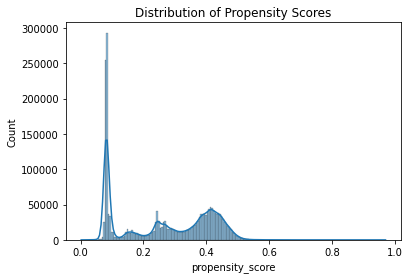

              DESYNPUF_ID  New_CHF_calc  propensity_score
0        00000B48BCF4AD29             0              0.25
1        0000141F2FECE9BC             0              0.08
2        000022FFDB0BE2C7             0              0.08
3        00002BE498BED936             0              0.08
4        00003539A5D77654             0              0.08
...                   ...           ...               ...
2142281  FFFFE00DD0AA36E0             0              0.15
2142282  FFFFE76452BF9DF6             0              0.08
2142283  FFFFEE90E1B4D0DF             1              0.42
2142284  FFFFF4859B6D7402             0              0.26
2142285  FFFFFC6B1F91F551             0              0.08

[2142256 rows x 3 columns]


In [71]:
# Create logistic regression model for propensity scores
logit = LogisticRegression()
final_df['propensity_score'] = logit.fit(final_df[covariates], final_df[outcome]).predict_proba(final_df[covariates])[:,1]

# Visualize propensity scores
sns.histplot(final_df['propensity_score'], kde=True)
plt.title('Distribution of Propensity Scores')
plt.show()


# Plot the distribution of propensity scores
# plt.figure(figsize=(10, 6))
# sns.histplot(treated['propensity_score'], kde=True, color='blue', label='Treated', stat='density', common_norm=False)
# sns.histplot(control['propensity_score'], kde=True, color='orange', label='Control', stat='density', common_norm=False)
# plt.title('Distribution of Propensity Scores by Treatment Status')
# plt.xlabel('Propensity Score')
# plt.ylabel('Density')
# plt.legend()
# plt.show()


print(final_df[['DESYNPUF_ID', 'New_CHF_calc', 'propensity_score']])

The distribution is multimodal, with several peaks. This suggests that there are distinct subgroups within the data that have similar covariate patterns. There is a significant peak near a propensity score of 0.2, indicating a large number of observations with a similar propensity to receive the treatment.

The propensity scores range from 0 to around 0.5, which indicates that there is a variation in the likelihood of receiving the treatment based on the observed covariates.

Ideally, for good propensity score matching, we want significant overlap in propensity scores between the treated and control groups. If there is limited overlap, it might be challenging to find good matches for some treated units. From the plot, it appears there is some overlap, but the distribution is skewed, indicating potential challenges in matching, particularly for those with high propensity scores. Given that there are very few observations with propensity scores close to 1, the effect of the skewed distribution should be minimal.


Covariates used for propensity score model:
['Age', 'Gender', 'Race', 'State', 'County', 'total_cost', 'average_cost', 'SP_ALZHDMTA', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']
Checking for missing values in covariates:
Age                         0
Gender                      0
Race                        0
State                       0
County                      0
total_cost                  0
average_cost                0
SP_ALZHDMTA                 0
SP_CHRNKIDN                 0
SP_CNCR                     0
SP_COPD                     0
SP_DEPRESSN                 0
SP_DIABETES                 0
SP_ISCHMCHT                 0
SP_OSTEOPRS                 0
SP_RA_OA                    0
SP_STRKETIA                 0
BENE_ESRD_IND               0
Distinct_I

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38248\1304732003.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['propensity_score'] = logit.fit(final_df[covariates], final_df[outcome]).predict_proba(final_df[covariates])[:,1]


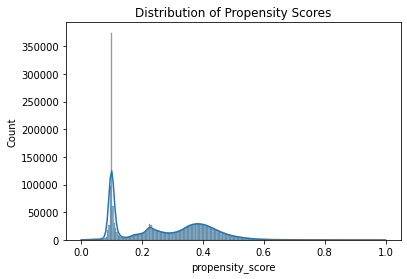

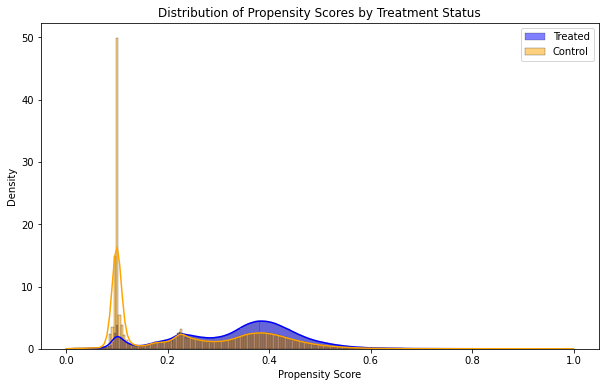

              DESYNPUF_ID  New_CHF_calc  propensity_score
0        00000B48BCF4AD29             0              0.09
1        0000141F2FECE9BC             0              0.14
2        000022FFDB0BE2C7             0              0.10
3        00002BE498BED936             0              0.10
4        00003539A5D77654             0              0.10
...                   ...           ...               ...
2142281  FFFFE00DD0AA36E0             0              0.17
2142282  FFFFE76452BF9DF6             0              0.10
2142283  FFFFEE90E1B4D0DF             1              0.55
2142284  FFFFF4859B6D7402             0              0.30
2142285  FFFFFC6B1F91F551             0              0.10

[2142256 rows x 3 columns]


In [73]:

# Ensure final_df, outcome, and covariates are correctly defined
outcome = 'New_CHF_calc'
covariates = [col for col in final_df.columns if col not in ['DESYNPUF_ID', 'Year', 'New_CHF_calc', 'propensity_score']]

print("Covariates used for propensity score model:")
print(covariates)

# Check if all covariates exist in final_df
for covariate in covariates:
    if covariate not in final_df.columns:
        print(f"Error: Covariate {covariate} not found in final_df")

# Check for missing values
print("Checking for missing values in covariates:")
print(final_df[covariates].isnull().sum())

# Create logistic regression model for propensity scores
logit = LogisticRegression()
try:
    final_df['propensity_score'] = logit.fit(final_df[covariates], final_df[outcome]).predict_proba(final_df[covariates])[:,1]
except KeyError as e:
    print(f"KeyError: {e}")
    print("Covariates used:")
    print(covariates)
    print("Columns in final_df:")
    print(final_df.columns)
    raise

# Visualize propensity scores
sns.histplot(final_df['propensity_score'], kde=True)
plt.title('Distribution of Propensity Scores')
plt.show()

# Separate treated and control groups
treated = final_df[final_df['New_CHF_calc'] == 1]
control = final_df[final_df['New_CHF_calc'] == 0]

# Plot the distribution of propensity scores by treatment status
plt.figure(figsize=(10, 6))
sns.histplot(treated['propensity_score'], kde=True, color='blue', label='Treated', stat='density', common_norm=False)
sns.histplot(control['propensity_score'], kde=True, color='orange', label='Control', stat='density', common_norm=False)
plt.title('Distribution of Propensity Scores by Treatment Status')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

print(final_df[['DESYNPUF_ID', 'New_CHF_calc', 'propensity_score']])

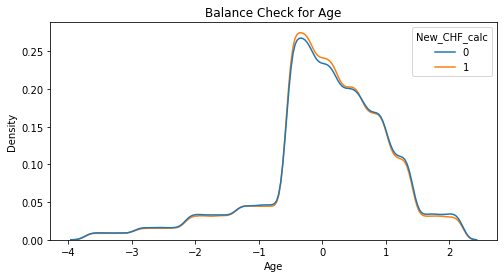

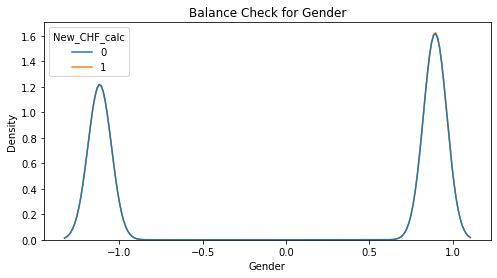

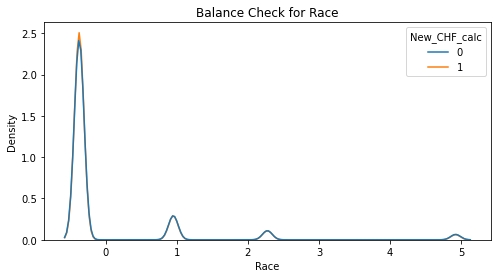

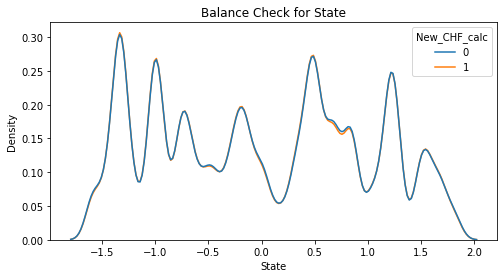

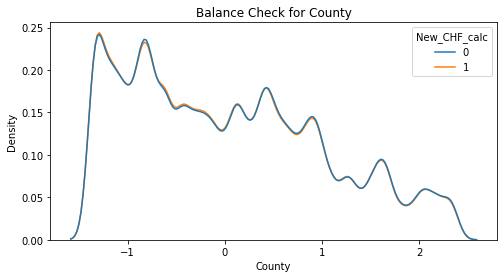

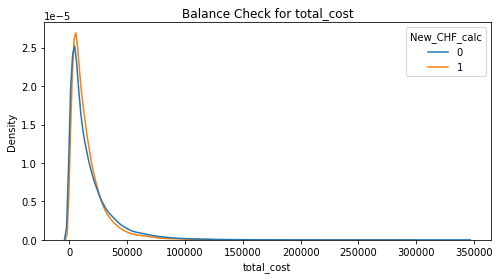

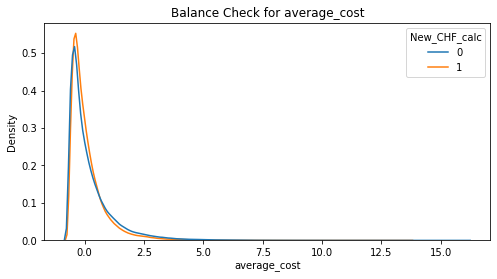

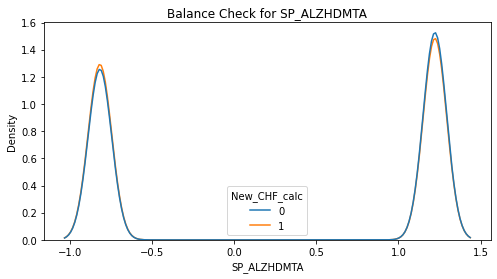

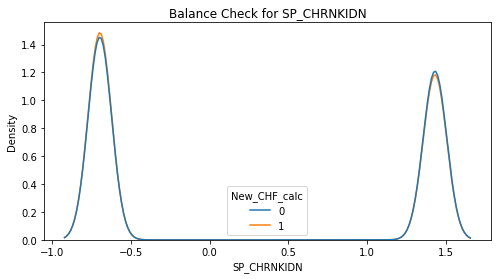

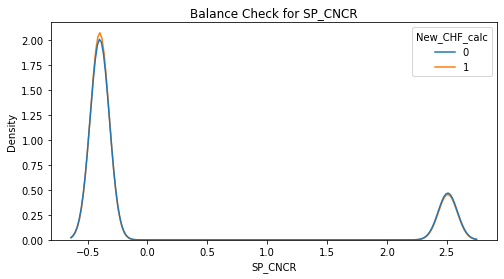

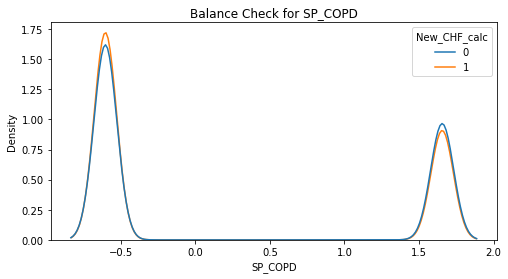

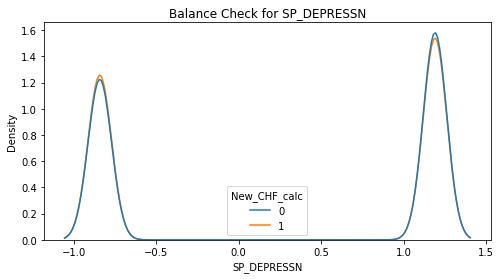

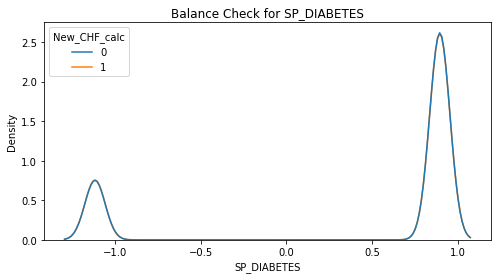

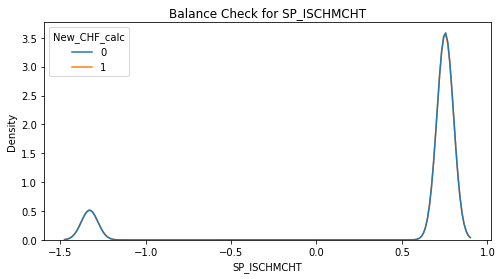

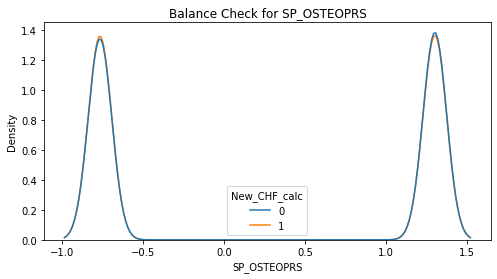

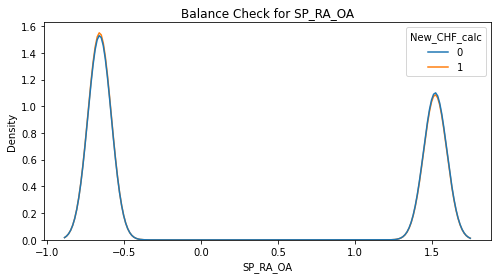

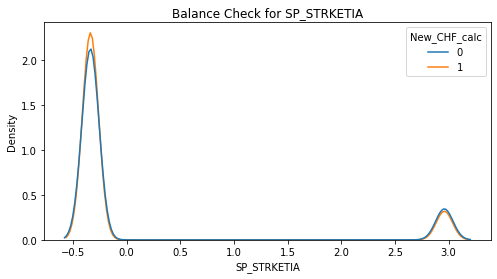

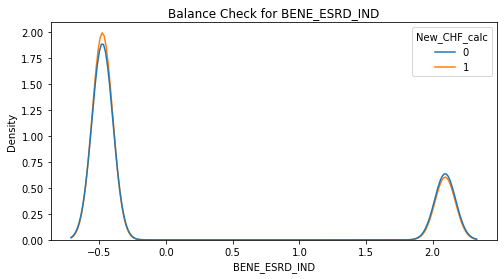

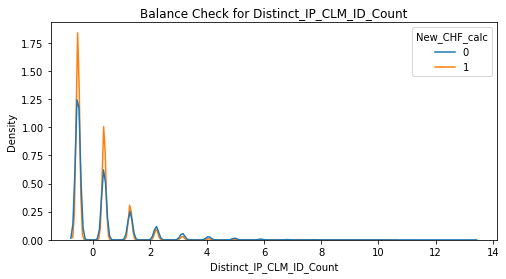

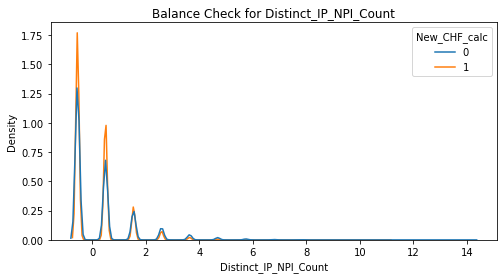

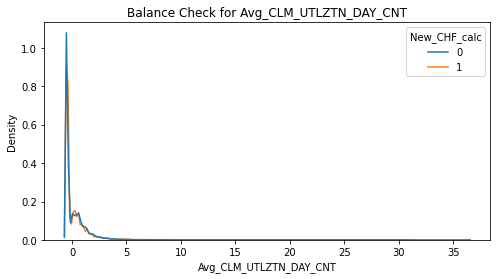

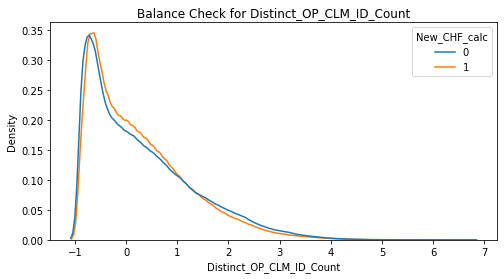

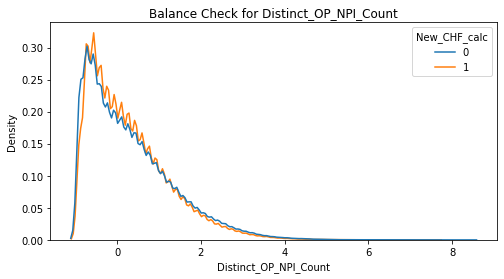

In [74]:
# Matching using nearest neighbors model on control group- (note: there are other methods we can use here)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors for treated group
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Create matched pairs
matched_control_indices = indices.flatten()
matched_control = control.iloc[matched_control_indices].reset_index(drop=True)

# Combine matched treated and control into one DataFrame
matched_data = pd.concat([treated, matched_control], ignore_index=True)

# Diagnostics: Check balance of covariates after matching
for covariate in covariates:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=matched_data, x=covariate, hue='New_CHF_calc')
    plt.title(f'Balance Check for {covariate}')
    plt.show()

The density plots for our covariates are almost perfectly overlapping for both the treated and control groups. This indicates that the distributions of covariates are very similar between the two groups.

Good overlap suggests that the matching process has successfully balanced the Age covariate between the treated and control groups.

In [75]:
start_time = time.time()

# Compare Costs
average_cost_chf_pos = matched_data[matched_data['New_CHF_calc'] == 1]['total_cost'].mean()
average_cost_chf_neg = matched_data[matched_data['New_CHF_calc'] == 0]['total_cost'].mean()

print(f"Average Cost for patients with new CHF: ${average_cost_chf_pos:.2f}")
print(f"Average Cost for patients without new CHF: ${average_cost_chf_neg:.2f}")

# Calculate the average treatment effect on the treated (ATT)
att = average_cost_chf_pos - average_cost_chf_neg
print(f"Average Intervention Effect on the CHF: ${att:.2f}")

# Bootstrap confidence intervals
n_bootstraps = 1000
att_bootstraps = []

for _ in range(n_bootstraps):
    bootstrap_sample = matched_data.sample(frac=1, replace=True)
    average_cost_treated_boot = bootstrap_sample[bootstrap_sample['New_CHF_calc'] == 1]['total_cost'].mean()
    average_cost_control_boot = bootstrap_sample[bootstrap_sample['New_CHF_calc'] == 0]['total_cost'].mean()
    att_bootstraps.append(average_cost_treated_boot - average_cost_control_boot)

ci_lower = np.percentile(att_bootstraps, 2.5)
ci_upper = np.percentile(att_bootstraps, 97.5)

print(f"95% CI for ATT: (${ci_lower:.2f}, ${ci_upper:.2f})")

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Average Cost for (CHF): $15914.91
Average Cost for (Non-CHF): $17647.90
Average Intervention Effect on the CHF (AIT metric): $-1732.99



KeyboardInterrupt



Before we proceed to a sensitivity analysis using the Caliper Method, let's review the math behind Propensity Score Matching.

#### Math Behind PSM:

- **Logistic Regression:**
  - Estimate the propensity score using logistic regression:

  $$
  \log \left( \frac{P(T=1|X)}{1 - P(T=1|X)} \right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p
  $$

- **Matching:**
  - For each treated unit \( i \), find a control unit \( j \) such that the absolute difference in their propensity scores is minimized:

  $$
  \text{Match}(i) = \min_j |\hat{e}(X_i) - \hat{e}(X_j)|
  $$

#### Math Behind Caliper Matching:

**Apply Caliper Constraint:**
   - Define a caliper (e.g., 0.05) which is the maximum allowable difference in propensity scores for matching.

   $$
   \text{Caliper} = 0.05
   $$

**Matching (Match Within Caliper):**
   - For each treated unit \( i \), find control units \( j \) such that the difference in their propensity scores is within the caliper:

   $$
   \text{Match}(i) = \{j : |\hat{e}(X_i) - \hat{e}(X_j)| \leq \text{Caliper}\}
   $$

**Select Closest Match (if multiple matches):**
   - If multiple control units fall within the caliper, select the closest one.


  $$
  |\hat{e}(X_i) - \hat{e}(X_j)| \leq \text{Caliper}
  $$


##### Similarities:

* Purpose: Both PSM and Caliper Matching aim to reduce confounding bias by creating a matched sample of treated and control units with similar covariate distributions.

* Propensity Score: Both methods rely on the propensity score, which is the probability of treatment assignment given the covariates.

* Balance Checking: Both methods require checking the balance of covariates after matching to ensure that the treated and control groups are comparable.

##### Differences:

1. Matching Criteria:
   * PSM: Typically uses nearest neighbor matching without a strict constraint on the allowable difference in propensity scores.
   * Caliper Matching: Imposes a caliper (maximum allowable difference) to ensure that matched pairs are very similar in terms of their propensity scores.

2. Bias-Variance Trade-off:
   * PSM: Can lead to better matching in terms of minimizing differences in propensity scores but might include poor matches if the distribution of propensity scores is wide.
   * Caliper Matching: Reduces bias by excluding poor matches but can increase variance because fewer matches may be found, leading to a smaller matched sample.

3. Implementation Complexity:
   * PSM: Generally simpler to implement with standard nearest neighbor matching.
   * Caliper Matching: Requires additional steps to impose the caliper constraint and handle cases where no suitable matches are found within the caliper.

In [41]:
start_time = time.time()

# Sensitvity Analysis: Caliper Matching
caliper = 0.05

caliper_matches = []

# Iterate over treated indices
for t_index, t_ps in zip(treated.index, treated['propensity_score']):
    caliper_match = control[(control['propensity_score'] >= t_ps - caliper) & (control['propensity_score'] <= t_ps + caliper)]
    if not caliper_match.empty:
        closest_match = caliper_match.iloc[(caliper_match['propensity_score'] - t_ps).abs().argsort()[:1]]
        caliper_matches.append(closest_match)

caliper_matched_control = pd.concat(caliper_matches)
caliper_matched_data = pd.concat([treated, caliper_matched_control]).reset_index(drop=True)

# Diagnostics: Check balance of covariates after caliper matching
for covariate in covariates:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=caliper_matched_data, x=covariate, hue='New_CHF_calc')
    plt.title(f'Caliper Matching Balance Check for {covariate}')
    plt.show()

# Compare Costs with Caliper Matching
average_cost_treated_caliper = caliper_matched_data[caliper_matched_data['New_CHF_calc'] == 1]['total_cost'].mean()
average_cost_control_caliper = caliper_matched_data[caliper_matched_data['New_CHF_calc'] == 0]['total_cost'].mean()

print(f"Average Cost for patients with CHF with Caliper Matching: ${average_cost_treated_caliper:.2f}")
print(f"Average Cost for patients without CHF with Caliper Matching: ${average_cost_control_caliper:.2f}")

att_caliper = average_cost_treated_caliper - average_cost_control_caliper
print(f"Average Cost Difference between patients with and without CHF: ${att_caliper:.2f}")

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))


KeyboardInterrupt



In [81]:
import pandas as pd
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_df, covariates, and outcome are already defined
# Define outcome and covariates
outcome = 'New_CHF_calc'
covariates = [col for col in final_df.columns if col not in ['DESYNPUF_ID', 'Year', 'New_CHF_calc', 'propensity_score']]

# Define optimize_dataframe function
def optimize_dataframe(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

# Optimize data types
final_df = optimize_dataframe(final_df)
treated = final_df[final_df['New_CHF_calc'] == 1]
control = final_df[final_df['New_CHF_calc'] == 0]

start_time = time.time()

caliper = 0.05
caliper_matches = []

# Batch processing function
def find_matches(treated_batch, control, caliper):
    batch_matches = []
    nn = NearestNeighbors(algorithm='ball_tree')
    nn.fit(control[['propensity_score']])

    distances, indices = nn.radius_neighbors(treated_batch[['propensity_score']], radius=caliper)

    for t_index, c_indices in zip(treated_batch.index, indices):
        if len(c_indices) > 0:
            t_ps = treated_batch.loc[t_index, 'propensity_score']
            caliper_match = control.iloc[c_indices]
            closest_match = caliper_match.iloc[(caliper_match['propensity_score'] - t_ps).abs().argsort()[:1]]
            batch_matches.append(closest_match)

    return batch_matches

# Process treated data in batches
batch_size = 1000  # Adjust this based on your memory capacity
for i in range(0, len(treated), batch_size):
    treated_batch = treated.iloc[i:i + batch_size]
    batch_matches = find_matches(treated_batch, control, caliper)
    caliper_matches.extend(batch_matches)

caliper_matched_control = pd.concat(caliper_matches)
caliper_matched_data = pd.concat([treated, caliper_matched_control]).reset_index(drop=True)

# Diagnostics: Check balance of covariates after caliper matching
for covariate in covariates:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=caliper_matched_data, x=covariate, hue='New_CHF_calc')
    plt.title(f'Caliper Matching Balance Check for {covariate}')
    plt.show()

# Compare Costs with Caliper Matching
average_cost_treated_caliper = caliper_matched_data[caliper_matched_data['New_CHF_calc'] == 1]['total_cost'].mean()
average_cost_control_caliper = caliper_matched_data[caliper_matched_data['New_CHF_calc'] == 0]['total_cost'].mean()

print(f"Average Cost for patients with CHF with Caliper Matching: ${average_cost_treated_caliper:.2f}")
print(f"Average Cost for patients without CHF with Caliper Matching: ${average_cost_control_caliper:.2f}")

att_caliper = average_cost_treated_caliper - average_cost_control_caliper
print(f"Average Cost Difference between patients with and without CHF: ${att_caliper:.2f}")

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))


KeyboardInterrupt



Let's calculate standardized mean differences (SMD) for each covariate to quantitatively assess balance.

SMD < 0.1: Indicates good balance, suggesting that the matching process has effectively balanced this covariate between the treated and control groups.
SMD 0.1 - 0.2: Indicates moderate imbalance, which may need further investigation or adjustment.
SMD > 0.2: Indicates poor balance, suggesting that the covariate may still be confounded and potentially bias the treatment effect estimation.

In [80]:
def compute_smd(df, covariate, treatment_col):
    treated = df[df[treatment_col] == 1][covariate]
    control = df[df[treatment_col] == 0][covariate]
    smd = (treated.mean() - control.mean()) / np.sqrt((treated.var() + control.var()) / 2)
    return smd

smd_results = {covariate: compute_smd(caliper_matched_data, covariate, 'New_CHF_calc') for covariate in covariates}

for covariate, smd in smd_results.items():
    print(f"SMD for {covariate}: {smd:.3f}")

NameError: name 'caliper_matched_data' is not defined

In [ ]:
for covariate in covariates:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=caliper_matched_data, x=covariate, hue='New_CHF_calc')
    plt.title(f'Caliper Matching Balance Check for {covariate}')
    plt.show()